In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score, GridSearchCV

In [2]:
df = pd.read_csv("../data/processed_data/1_data_clearing/1_clearing_cars.csv")
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3954 entries, 0 to 3953
Data columns (total 13 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   model_auta       3954 non-null   object
 1   cena             3954 non-null   int64 
 2   rok              3954 non-null   int64 
 3   najezd           3954 non-null   int64 
 4   stav             3954 non-null   object
 5   vykon            3954 non-null   int64 
 6   objem_motoru     3954 non-null   int64 
 7   typ_paliva       3954 non-null   object
 8   typ_prevodovky   3954 non-null   object
 9   typ_karoserie    3954 non-null   object
 10  barva_exterieru  3890 non-null   object
 11  metaliza         3890 non-null   object
 12  kraj             3924 non-null   object
dtypes: int64(5), object(8)
memory usage: 401.7+ KB
None


In [3]:
#Priprava dat pro modelovani

#Doplneni chybejicich hodnot
df["barva_exterieru"] = df["barva_exterieru"].fillna("neuvedeno")
df["metaliza"] = df["metaliza"].map({1: "ano", 0: "ne"}).fillna("neuvedeno")

#Predzpracovani vstupnich promennych X
df = pd.get_dummies(df, columns=["model_auta", "typ_karoserie", "typ_paliva", "typ_prevodovky", "metaliza", "barva_exterieru"])
df.columns = df.columns.str.replace(' ', '_')
df.columns = df.columns.str.lower()
df = df.drop(columns=["kraj", "stav"])

X = df.drop(columns=['cena']) # Odstraneni atributu ceny

#Volba cilove promenne
y = df["cena"]

print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3954 entries, 0 to 3953
Data columns (total 58 columns):
 #   Column                              Non-Null Count  Dtype
---  ------                              --------------  -----
 0   cena                                3954 non-null   int64
 1   rok                                 3954 non-null   int64
 2   najezd                              3954 non-null   int64
 3   vykon                               3954 non-null   int64
 4   objem_motoru                        3954 non-null   int64
 5   model_auta_x1                       3954 non-null   bool 
 6   model_auta_x2                       3954 non-null   bool 
 7   model_auta_x3                       3954 non-null   bool 
 8   model_auta_x4                       3954 non-null   bool 
 9   model_auta_x5                       3954 non-null   bool 
 10  model_auta_x6                       3954 non-null   bool 
 11  model_auta_x7                       3954 non-null   bool 
 12  model_

In [4]:
#Nastaveni modelu
tree_rand = (RandomForestRegressor(random_state=42))

# Definice mrizky hyperparametru
param_grid = {
    "n_estimators": [50, 100, 200],
    "max_depth": [5, 10, None],
    "min_samples_split": [2, 5]
}

#Nastaveni GridSearchCV pro automatickou optimalizaci parametru pomoci desetinasobne krizove validace
grid_search = GridSearchCV(
    estimator=tree_rand,
    param_grid=param_grid,
    scoring="neg_mean_squared_error",
    cv=10,
    n_jobs=-1,
    verbose=2
)

#Vypocet score v krizove validaci
scores = cross_val_score(tree_rand, X, y, scoring="neg_mean_squared_error", cv=10)

#Trenovani modelu
grid_search.fit(X, y)

#Vytisknout nejlepsi parametry
print("Nejlepší parametry:", grid_search.best_params_)

#Volba nejlepsiho modelu
tree_rand = grid_search.best_estimator_

#Vypocet predikovanych hodnot
y_pred = tree_rand.predict(X)

#Odchylka
rmse_scores = np.sqrt(-scores)

#Prumerna relativni chyba
relative_errors = np.abs(y_pred - y) / y

#print("RMSE:", rmse)
print("MAPE (průměrná relativní chyba):", relative_errors.mean())
print("RMSE (křížová validace):", rmse_scores.mean())
print("Odchylka:", rmse_scores.std())

Fitting 10 folds for each of 18 candidates, totalling 180 fits
Nejlepší parametry: {'max_depth': None, 'min_samples_split': 5, 'n_estimators': 50}
MAPE (průměrná relativní chyba): 0.06613310379400615
RMSE (křížová validace): 311123.5484658877
Odchylka: 296239.8620073656


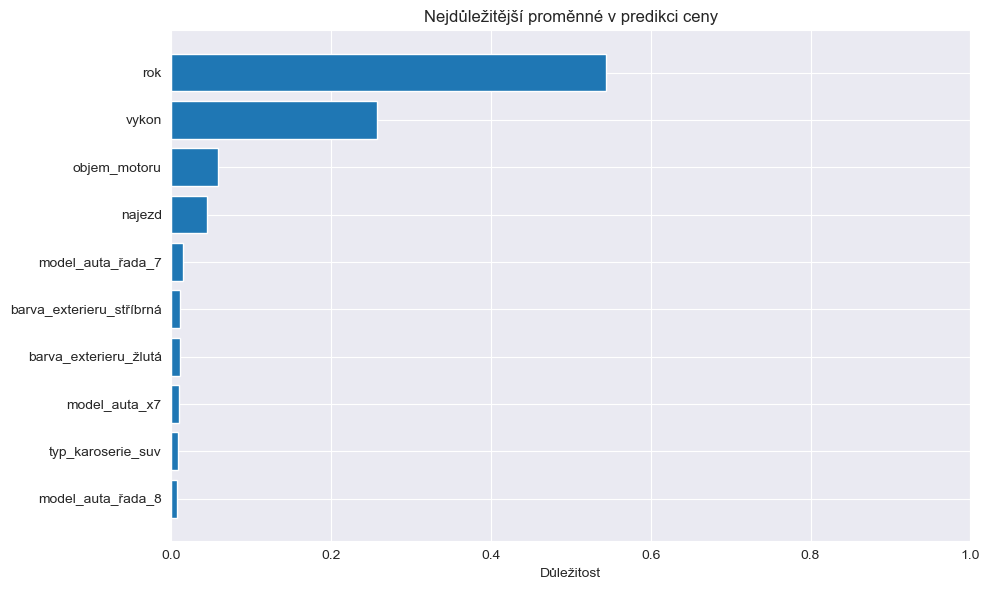

In [5]:
#Vizualizace dulezitosti promennych
importances = tree_rand.feature_importances_
features = X.columns
indices = np.argsort(importances)[-10:]  # Top 10 promennych

plt.figure(figsize=(10, 6))
plt.barh(range(len(indices)), importances[indices], align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlim([0, 1])
plt.xlabel("Důležitost")
plt.title("Nejdůležitější proměnné v predikci ceny")
plt.tight_layout()

plt.savefig("../figures/3_random_forest/feature_importances.png")  # Ulozeni

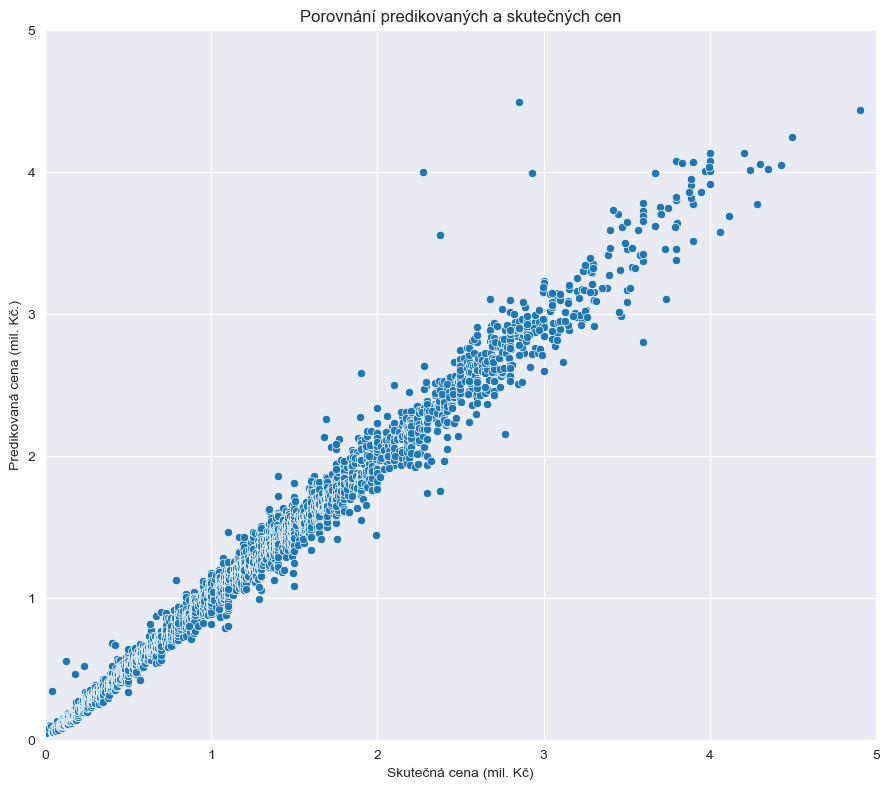

In [6]:
#Porovnani skutecnych cen s predikovanymi
plt.figure(figsize=(9, 8))
sns.scatterplot(x=y/1000000, y=y_pred/1000000)
plt.xlabel("Skutečná cena (mil. Kč)")
plt.ylabel("Predikovaná cena (mil. Kč.)")
plt.title("Porovnání predikovaných a skutečných cen")
plt.ylim([0,5])
plt.xlim([0,5])
plt.grid(True)
plt.tight_layout()

plt.savefig("../figures/3_random_forest/scatterplot_porovnani_cen.png")  # Ulozeni